In [7]:
# Fix RTL in nbviewer
from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedMarkdown { direction: rtl;} 
.jp-RenderedMarkdown p { text-align: right;}
.jp-Cell.jp-CodeCell.jp-Notebook-cell:first-of-type {
    display: none;
}
</style>
""")

# ניתוח סנטימנטלי של תסריטים כבסיס לסיווג ז'אנרים 
**הצעת פרויקט - איתם יוגב**

## מטרת הפרויקט ומוטיבציה

המטרה שלי בפרוייקט היא ניתוח סנטימנטלי של סצנות סרטים, וניסיון לקישור בין רמות הסנטימנטים לאורך הסרט ובין סיווג הז'אנרים של הסרט.
המשימה של סיווג סרטים לז'אנרים נראית פשוטה ממבט ראשון אך היא אינה טריוויאלית, שכן לא ניתן להסיק אותה באופן מיידי ממידע כלשהו על הסרט, והיא מצריכה ידע רחב ותושמת לב לדקויות. כמו כן, ז'אנר הוא אינו מאפיין בודד אחד, ובדרך כלל סרט יכול להשתייך לכמה ז'אנרים, וגם זה במידות שונות.

הרבה חברות סטרימינג גדולות כמו נטפליקס משתמשות בסיווג ז'אנרים כדי לזהות דמיון בין תכנים, וכך לתת למשתמש הצעות שיותר יתאימו לטעמו. קיימות שיטות רבות לסיווג ז'אנרים בעזרת למידת מכונה המשתמשות למשל בכותרת הסרט, תיאור הסרט טריילר ועוד. 

בפרוייקט שלי אבחן את הרעיון של סנטימנטים במשפטים מתוך הסרט כבעלי קורלציה לז'אנרים של הסרט. ניתוח התוכן עצמו של הסרט מאתגר יותר מאשר ניתוח נתונים נלווים, אך הוא מאפשר ניתוח מעמיק יותר והתייחסות לפרטים נוספים חשובים כמו ציר הזמן, הדמויות השונות, עוצמת הרגש וכו' מה שלא ניתן כאשר מנתחים למשל את התקציר.
בנוסף מציאת קורלציה בין סנטימנטים וז'אנרים יכולה לעבוד גם בכיוון ההפוך - בהינתן סרט בעל ז'אנר מסויים, תהיה אפשרות להגיד מהן התכונות של הדיאלוגים במהלך הסרט שעלינו לחפש בסרט מסוג זה. 


## נתונים

מאגר הנתונים הנוח ביותר לעבודה שמצאתי עבור הפרויקט הוא מאגר דיאלוגים בסרטים של אוניב' קורנל, שנמצא ב- 
[Kaggle](https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus)

המאגר מכיל מידע טקסטואלי שחולץ מ-617 תסריטי סרטים באנגלית, ו-304,713 משפטים שנאמרו בסרטים. עבור כל סרט הוא מכיל מידע על השורות שנאמרו, אילו שורות שייכות לאותו דיאלוג או שיחה בסרט, על ידי מי נאמרה השורה ומיהן הדמויות בסרט. כמו כן לכל סרט יש מידע שנלקח מIMDB המכיל גם את הז'אנרים.

להלן טעינת הנתונים ל-DataFrames של pandas:

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [7]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')

line_cols = ['line_id', 'character_id', 'movie_id', 'character_name', 'text']
lines = pd.read_table('./datasets/movie-dialog-corpus/movie_lines.tsv', sep='\t',
                      header=None, names=line_cols, index_col='line_id', on_bad_lines='skip')

conv_cols = ['first_char', 'second_char', 'movie_id', 'line_ids']
convos = pd.read_table(
    './datasets/movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None, names=conv_cols, on_bad_lines='skip')


In [3]:
meta.shape[0]

617

In [4]:
meta.head()

,title,year,rating,no. votes,genres
movie_id,,,,,
m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


## ניתוח סנטימנטלי

הניתוח הסנטימנטלי (נ"ס) הרצוי הוא ניתוח מתקדם יותר מניתוח בינארי חיובי-שלילי, ולכן אשתמש בניתוח רגשות כמו כעס, שמחה, פחד. האלגוריתם עצמו הוא מודל מאומן מראש שהורד מ-
[huggincface](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion)

In [26]:
from transformers import pipeline
classifier = pipeline("text-classification",
                      model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=None)

In [24]:
classifier("This is so unbelievable")

[[{'label': 'surprise', 'score': 0.8266220688819885},
  {'label': 'joy', 'score': 0.10373222082853317},
  {'label': 'fear', 'score': 0.05381690338253975},
  {'label': 'anger', 'score': 0.007986416108906269},
  {'label': 'sadness', 'score': 0.005756333936005831},
  {'label': 'love', 'score': 0.0020860331133008003}]]

## חלוקה לדיאלוגים

לא ניתן לבצע ניתוח סנטימנטלי ראליסטי לתוכנו של הסרט ללא חלוקה כלשהי, שכן ניתוח של הסרט בשלמותו הוא ארוך מדי ודורש מודל מסוג אחר, וכן מאבד את מימד הזמן. מצד שני ניתוח בנפרד של כל משפט בסרט יכול לקחת הרבה זמן. לכן החלוקה של סרט לדיאלוגים כפי שנמצאת במאגר מתאימה למטרתנו.

למרות החלוקה לדיאלוגים, עדיין עלינו להגביל את אורך הטקסט שאנו מעבירים למודל, כיוון שהמודל מוגבל למספר מסויים של קלטים. לאחר ניסוי וטעייה הגעתי למספר 1400 שהוא האורך המקסימלי של הקלט שאותו אנתח. באופן כללי הגבלת אורך הטקסט תצמצם את מרווח הטעייה ותחזק את תוצאת הניתוח.

כעת נוכל לחלץ את רשימת הדיאלוגים בכל סרט:

In [24]:
def str_to_list(str: str):
    return str.strip('\'[]').split("\' \'")

max_length = 1400

def get_line_groups(lines: list[str]):
    curr_group = None
    for line in lines:
        if not curr_group:
            curr_group = line
        elif len(curr_group) + len(line) > max_length:
            yield curr_group
        else:
            curr_group = ' '.join([curr_group, line])

def get_lines_text(row):
    try:
        line_texts = [lines.loc[id].text[:max_length] for id in str_to_list(row['line_ids'])]
        if sum([len(s) for s in line_texts]) <= max_length:
            return [' '.join(line_texts)]
        return get_line_groups(line_texts)
    except:
        return None

def get_dialog_texts():
    for i in tqdm(range(len(convos))):
        convo = convos.iloc[i]
        texts = get_lines_text(convo)
        if not texts:
            continue
        for text in texts:
            yield {
                'first_char': convo.first_char,
                'second_char': convo.second_char,
                'movie_id': convo.movie_id,
                'text': text
            }

In [10]:
dialog_texts = pd.DataFrame(get_dialog_texts())

  0%|          | 0/83097 [00:00<?, ?it/s]

In [15]:
dialog_texts.head()

,first_char,second_char,movie_id,text
0,u0,u2,m0,Can we make this quick? Roxanne Korrine and A...
1,u0,u2,m0,You're asking me out. That's so cute. What's ...
2,u0,u2,m0,No no it's my fault -- we didn't have a proper...
3,u0,u2,m0,Why? Unsolved mystery. She used to be really ...
4,u0,u2,m0,Gosh if only we could find Kat a boyfriend... ...


## ניתוח ראשוני

כעת כשיש לנו את הטקסטים של הדיאלוגים ביד, נוכל לבצע ניתוח בעזרת ה-classifier. כיוון שהתהליך ארוך (עבור 600 הסרטים התהליך לוקח כשעה), לאחר ניתוח כל סרט נשמור את הנתונים לקובץ להמשך:

In [25]:
def get_emotion_feats(classifier_res: list[list[dict]]):
  return { x['label']: x['score'] for x in classifier_res[0] }

def get_dialog_emotions(df):
    for i in range(df.shape[0]):
        dialog = df.iloc[i]
        try:
          txt = dialog.text
          feats = get_emotion_feats(classifier(txt))
          feats['movie_id'] = dialog.movie_id
          feats['text'] = txt
        except:
          print('error, length: ', len(dialog.text))
        yield feats
        
def get_movie_emots(movie_id):
    return pd.DataFrame(get_dialog_emotions(dialog_texts[dialog_texts['movie_id'] == movie_id]))

In [8]:
movie_emots = pd.DataFrame(columns=[])

for i in tqdm(range(100)):
    movie = meta.iloc[i]
    movie_id = meta.index[i]
    emots = get_movie_emots(movie_id)
    movie_emots = pd.concat([movie_emots, emots])
    movie_emots.to_pickle('data/movie_emots')

  0%|          | 0/100 [00:00<?, ?it/s]

נוכל לקבל רושם ראשוני מהתוצאות על ידי ויזואליזציה של הרגשות בסרט לדוגמה לאורך זמן, במקרה הזה הסרט "2001: A Space Odyssey"

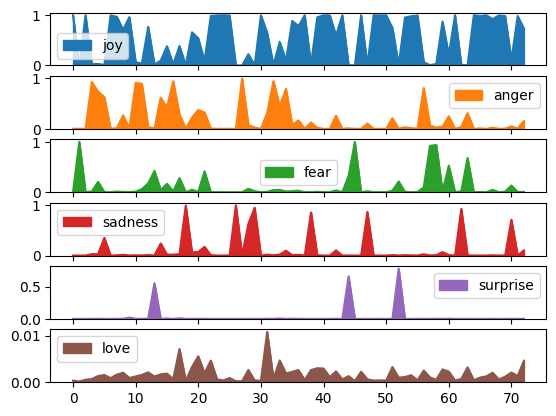

In [13]:
movie_emots[movie_emots['movie_id'] == 'm3'].plot.area(subplots=True)
plt.show()

לאחר שניתחנו 100 סרטים, נבצע חקר ראשוני של הנתונים בעזרת חישוב ממוצע הערכים של כל רגש עבור כל סרט: 

In [21]:
movie_avg_emots = movie_emots.drop(['text'], axis=1).groupby('movie_id').agg(
        np.average)
movie_avg_emots.head()

,joy,anger,fear,sadness,surprise,love
movie_id,,,,,,
m0,0.398787,0.378822,0.062813,0.114356,0.012573,0.032650
m1,0.413788,0.388833,0.100575,0.087057,0.002582,0.007166
m10,0.375505,0.383896,0.050734,0.168364,0.011126,0.010376
m11,0.381490,0.393497,0.099394,0.105984,0.009496,0.010138
m12,0.412226,0.294726,0.129133,0.130878,0.001741,0.031296


ניתן לראות כי הרגש שמחה למשל מקבל משקל גדול יותר בדרך כלל משאר הרגשות, לכן כדי להשוות בין סוגי הרגשות נבצע נרמול של העמודות:

In [22]:
normalized = (movie_avg_emots-movie_avg_emots.mean())/movie_avg_emots.std()
normalized.head()

,joy,anger,fear,sadness,surprise,love
movie_id,,,,,,
m0,0.050918,0.593540,-1.009147,-0.256940,-0.062656,0.706516
m1,0.259272,0.734072,-0.196926,-1.034451,-1.180378,-1.000318
m10,-0.272446,0.664765,-1.268952,1.281266,-0.224569,-0.785349
m11,-0.189317,0.799534,-0.222310,-0.495395,-0.406811,-0.801240
m12,0.237587,-0.586907,0.417335,0.213626,-1.274437,0.615820


כעת ננסה לבדוק את הקשר בין הז'אנרים לממוצע הרגשות בסרט:

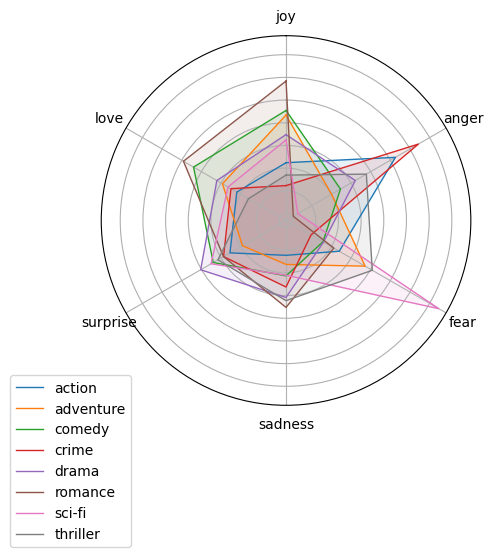

In [25]:
from math import pi

normalized['genres'] = meta.loc[normalized.index]['genres'].apply(
    lambda x: str_to_list(x))
exploded = normalized.explode('genres')
genre_avgs = exploded.groupby('genres').agg(np.average)
genre_counts = exploded.groupby('genres').size()

def show_spider(data: pd.DataFrame, label_col: str = None):
    categories = (data.drop(label_col, axis=1) if label_col else data).columns.to_list()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.axes.get_yaxis().set_ticklabels([])
    for id, v in data.iterrows():
        values = (v.drop(label_col) if label_col else v).values.tolist()
        values += values[:1]
        label = str(v[label_col]) if label_col else id
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    if len(data) > 1:
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

show_spider(genre_avgs[genre_counts[genre_avgs.index] > 18])

למרות שביצענו ניתוח מאוד ראשוני ופשטני של הנתונים, קיבלנו תוצאות מרשימות בגרף לעיל שנראות לעין כהגיוניות מאוד, כמו העובדה שסרטי רומנטיקה בעלי רגשות חזקים יותר של אושר ואהבה, סרטי פשע בעלי רגש כעס חזק יותר וכן הלאה.

## אתגרים

- מאגר הנתונים לעיתים מכיל שורות לא תקינות, וכן טקסטים שמכילים תווים שלא קשורים לחלקי הדיבור, מלבד תווים שרלוונטיים לניתוח סנטימנטלי כמו "?". כדי להתגבר על זה נדרש לעשות preprocessing על הטקסטים ולהתאים אותם למטרה
- הרבה מהדיאלוגים בסרט הם בעלי סאבטקסט וטונים שלא ניתן לחלץ מתוך הטקסט לבדו. למשל השורה הבאה:

In [34]:
classifier("It's alive!")

[[{'label': 'joy', 'score': 0.9411875605583191},
  {'label': 'anger', 'score': 0.02787075936794281},
  {'label': 'fear', 'score': 0.016459660604596138},
  {'label': 'surprise', 'score': 0.006774833891540766},
  {'label': 'sadness', 'score': 0.005960711278021336},
  {'label': 'love', 'score': 0.0017464046832174063}]]

שורה זו יכולה לקבל מובנים שונים בהתאם להקשר (שבמקרה הזה בדרך כלל יגיע בסרט אימה עם סנטימנט של פחד). לכן מלכתחילה לא ניתן לצפות כי ניתוח הטקסט בלבד יהיה מספיק כדי לקבל תוצאות מאוד מדויקות


## מטרות להמשך

### המשך הניתוח

כפי שהזכרתי, הניתוח לעיל הוא פשטני ומאבד את מימד הזמן ברגע שאיחדנו את המידע הסנטימנטלי תחת ממוצע לכל סרט. אחת המטרות שלי בפרוייקט היא להמשיך לנתח את הנתונים כסדרה של סצנות, ולהפעיל אלגוריתמים של למידה המתייחסים לסנטימנטים לאורך זמן. למשל התייחסות למידע כ-TimeSeries והפעלת אלגוריתמים שקשורים אליו.

כמו כן, הנ"ס שנעשה מובצע על דיאלוג מלא בין כמה דמויות, ואינו מתחשב בשונות בין הדמויות. במידה ונוכל לחלק את עוצמת הסנטימנטים ביחס לכל דמות, ייתכן ונקבל תמונה מלאה יותר שתיתן תוצאות אחרות, כאשר למשל בסרטים מקטגוריה מסויימת יש סוגי דמויות קבועים (הגיבור, החבר המצחיק, הדכאוני וכו') 

בנוסף, כדי להגיע למצב של סיווג ז'אנרים קיים צורך בשימוש בסיווג רב-תגיות או multi-labeling. כל סרט יכול להתאים לכמה ז'אנרים, וגם בתרשים העכביש למעלה ניתן לשער שהתמונה היא חלקית בגלל חלוקות לז'אנרים אחרים, למשל סרטי מד"ב שלפעמים הם אימה, ולפעמים הם דרמה או אפילו קומדיה.

דבר אחר שהייתי רוצה לבדוק הוא האם ניתן לבצע למידה בלתי-מפוקחת ו-clustering כדי להגיע לתוצאות מעניינות - האם ניתן לקבץ סרטים דומים על פי קטגוריות אחרות מלבד הז'אנרים הקלאסיים.

### תמיכה בסרטים בעברית

כדי לבצע את אותה משימה עבור סרטים בעברית, נדרש שימוש במאגר מידע ובמודל נ"ס אחר שמותאם לעברית. 

עבור איסוף המידע, אני בוחן אפשרות לאסוף מידע מתסריטים בעברית שנמצאים באינטרנט, ו/או כתוביות בעברית לסרטים מ-OpenSubtitles. האיסוף הוא יותר מאתגר במקרה הזה, שכן אין חלוקה ברורה לשורות ודיאלוגים כפי שיש במאגר של קורנל. 

לגבי מודל לנ"ס, אני חושב להשתמש במודל [קיים שנקרא HeBERT](https://github.com/avichaychriqui/HeBERT) שנותן מענה דומה בעברית